In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

## Good combs

->
hidden_size = 50      
num_layers = 3        
output_size = 1       
learning_rate = 0.0001

val_loss= ~0.017

In [16]:

# Hyperparameters
lookback_window = 7  # Number of time steps
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window
input_size = 6        # Number of features (univariate = 1)
output_size = 1       # Predicting one value
hidden_size = 50      # Number of LSTM neurons
num_layers = 3        # Number of LSTM layers
learning_rate = 0.0001
epochs = 0
batch_size = 32

#TODO: USD/TRY exchange rate input
#TODO: Faiz Enflasyon ve Piyasa Katılımcıları Anketi input

#TODO: Takas Verisi (model iyi sonuçlar vermezse son çare olarak kullanılabilir)

#TODO: Vadeli İşlem ve Opsiyon Borsası (VIOP) input (Çok karmaşıklaştırıyor gelecekte belki)
#TODO: Anlık Aracı Kurum Dağılımı  (çok karıştırabilir)



In [17]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32

In [27]:
unnecessaryColumns=["Date","Pct_Change"]

from Scaler import Scaler
from sklearn.preprocessing import StandardScaler


# Can't do with minMax scaler we need Z scaler
#Rewrite Time
scaler = Scaler(0,50)
zScalerDic={}


def df_to_X_y(df,zScaler,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = zScaler.fit_transform(lightWeightDf.to_numpy())
  # df_as_np = lightWeightDf.to_numpy()

  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
  return np.array(X), np.array(y)

In [28]:
XAll = np.zeros(1, dtype=np.int32)
yAll = np.zeros(1, dtype=np.int32)

for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))
    currentScaler=StandardScaler()
    zScalerDic[allcsvs[i]]=currentScaler
    Xtemp,yTemp=df_to_X_y(rawData, currentScaler, lookback_window)
    nameTemp=np.array([allcsvs[i]]*yTemp.shape[0])

    if(XAll.shape[0] == 1 and yAll.shape[0] == 1):
        XAll=Xtemp
        yAll=yTemp
        nameAll=nameTemp
    else:
        XAll=np.concatenate((XAll,Xtemp),axis=0)
        yAll=np.concatenate((yAll,yTemp),axis=0)
        nameAll=np.concatenate((nameAll,nameTemp),axis=0)
XAll=scaler.fit_transform(XAll)
yAll=scaler.fit_transform(yAll)

# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [24]:
XAll.shape, yAll.shape, nameAll.shape

((57412, 7, 6), (57412,), (57412,))

In [29]:
XAll[:5,1,:], yAll[:5], nameAll[:5]

(array([[13.92315264, 14.18317764, 13.83897119, 14.01086309,  7.91110531,
          0.05918395],
        [13.92219138, 14.19835368, 13.85279951, 14.02819236,  7.7134293 ,
          0.05918395],
        [13.93660782, 14.20783847, 13.85971367, 14.03396878,  7.87773715,
          0.05918395],
        [13.93468604, 14.19835392, 13.8379836 , 14.00412414,  7.9388673 ,
         16.62497361],
        [13.90873621, 14.16515611, 13.7945234 , 13.96176349,  7.78521834,
          8.34207878]]),
 array([12.06184055, 12.10136227, 12.07704105, 12.09426853, 12.13987108]),
 array(['AEFES.IS.csv', 'AEFES.IS.csv', 'AEFES.IS.csv', 'AEFES.IS.csv',
        'AEFES.IS.csv'], dtype='<U12'))

In [13]:
def shuffle_data(X, y, names):
    """
    Shuffle the data while maintaining the correspondence between X and y.

    Parameters:
    X (numpy.ndarray): The input features tensor.
    y (numpy.ndarray): The target array.

    Returns:
    tuple: Shuffled X and y tensors.
    """
    assert len(X) == len(y), "X and y must have the same length."
    assert len(y) == len(names), "y and names must have the same length."

    # Generate a random permutation of indices
    #TODO add a seed for reproducibility
    #add seed to the code below
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    # print(indices[:5])
    # Shuffle X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    name_shuffled = names[indices]
    
    return X_shuffled, y_shuffled, name_shuffled

In [14]:
X_shuffled, y_shuffled, name_shuffled = shuffle_data(XAll, yAll, nameAll)

In [117]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_shuffled, y_shuffled, name_shuffled):
        # #NOTE shuffling is automatically done in the dataloader
        # X_shuffled, y_shuffled = shuffle_data(X, y)
        self.dataX = torch.tensor(X_shuffled, dtype=torch.float32)
        self.dataY = torch.tensor(y_shuffled, dtype=torch.float32)
        self.names = torch.tensor(name_shuffled, dtype=torch.string)
        
    def __len__(self):
        return self.dataX.size(0)

    def __getitem__(self, idx):
        sequence = self.dataX[idx, :]
        target = self.dataY[idx]
        name = self.names[idx]
        return sequence, target, name

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
#try hidden_size*2 if bidirectional is True
    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]  # Take the output at the last time step
        return self.fc(last_output)


In [118]:
import torch.nn.functional as F


#TODO test and utilize
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, lstm_outputs):
        # lstm_outputs: [batch_size, seq_len, hidden_dim]
        attention_scores = self.attention_weights(lstm_outputs).squeeze(-1)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len]
        weighted_output = torch.sum(lstm_outputs * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_dim]
        return weighted_output, attention_weights
    

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AttentionMechanism(hidden_dim * (2 if bidirectional else 1))
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        attention_out, attention_weights = self.attention(lstm_out)  # [batch_size, hidden_dim], [batch_size, seq_len]
        output = self.fc(attention_out)  # [batch_size, output_dim]
        return output, attention_weights

In [119]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


In [120]:
X_train = X_shuffled[:int(0.8*len(X_shuffled))]
y_train = y_shuffled[:int(0.8*len(y_shuffled))]
name_train = name_shuffled[:int(0.8*len(name_shuffled))]

X_val = X_shuffled[int(0.8*len(X_shuffled)):]
y_val = y_shuffled[int(0.8*len(y_shuffled)):]
name_val = name_shuffled[int(0.8*len(name_shuffled)):]

In [121]:
trainDataset = TimeSeriesDataset(X_train, y_train,name_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
#Dataset for validation
valDataset = TimeSeriesDataset(X_val, y_val,name_val)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

# Cross-validation: On non-overlapping sequential splits for evaluation.

In [122]:
def train_one_epoch(model,optimizer,criterion,train_loader):
    model.train()
    model.to(device)
    epoch_loss = 0

    for sequences, targets, name in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
    


def validate(model,criterion,val_loader):
    model.eval()
    model.to(device)
    val_loss = 0
    DA=0

    with torch.no_grad():
        for sequences, targets, name in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
    return val_loss
    # print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

## Some Potenetial Metrics to evaluate models


Directional Accuracy
Measures how often the predicted direction (up or down) matches the actual direction.
Formula: 
DA=Number of Correct Directions/Total Predictions

Cons: Ignores magnitude of errors.

## OR
Profit and Loss (PnL) simulation for trading applications.

In [123]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [124]:

valLosses=[]
trainLosses=[]
# Training loop
for epoch in range(epochs):

    epoch_loss=train_one_epoch(model,optimizer,criterion,train_loader)
    val_loss=validate(model,criterion,val_loader)
    valLosses.append(val_loss)
    trainLosses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

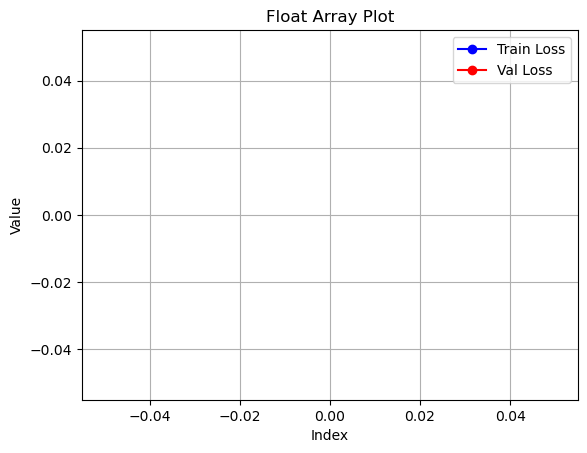

In [125]:
import matplotlib.pyplot as plt
import numpy as np
startPoint=20
# Example float array
val_array = valLosses[startPoint:]
train_array = trainLosses[startPoint:]

# Create an x-axis for the data points
x = np.arange(len(train_array))
y = np.arange(len(val_array))

# Plot the graph
plt.plot(x, train_array, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(y, val_array, marker='o', linestyle='-', color='r', label='Val Loss')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [126]:
# Extract one batch of data for testing
model.to(device)
for sequences, targets in train_loader:
    testInput = sequences.to(device)  # Sequence data
    # testInput.to(device)
    print(f"Test Input Shape: {testInput.shape}")
    realOutput = targets   # Ground truth output
    break

# Ensure the model is in evaluation mode
model.eval()

# Predict using the model
with torch.no_grad():  # Disable gradient calculations for inference
    predicted = model(testInput).squeeze()  # Forward pass through the model

# Check shapes and results
print(f"Predicted Output Shape: {predicted.shape}")
print(f"First Prediction: {predicted[0].item()}")
print(f"Actual Output (First Target): {realOutput[0].item()}")

predicted
# testInput.shape

Test Input Shape: torch.Size([32, 7, 6])
Predicted Output Shape: torch.Size([32])
First Prediction: 0.05473044142127037
Actual Output (First Target): 0.08542854338884354


tensor([0.0547, 0.0560, 0.0553, 0.0560, 0.0556, 0.0560, 0.0565, 0.0554, 0.0554,
        0.0532, 0.0561, 0.0554, 0.0548, 0.0560, 0.0550, 0.0558, 0.0509, 0.0554,
        0.0551, 0.0553, 0.0605, 0.0550, 0.0553, 0.0335, 0.0561, 0.0445, 0.0524,
        0.0556, 0.0551, 0.0551, 0.0513, 0.0560], device='cuda:0')

In [127]:
realOutput[-1]

tensor(0.0071)

In [128]:
sequences[-1,:,3]

tensor([0.0075, 0.0073, 0.0072, 0.0071, 0.0070, 0.0070, 0.0070])

In [129]:
scaler.inverse_transform(sequences[-1].to('cpu').numpy())[:,3]

array([1.738073 , 1.7128551, 1.6981272, 1.670136 , 1.6608056, 1.6608056,
       1.6608056], dtype=float32)